In [16]:
!pip install hmmlearn

Cell 1: Import Libraries

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

sns.set_style('whitegrid')

Cell 2: Load and Prepare the Data

In [18]:
# Load the features, specifying the first column (index 0) is the index.
# We also skip the extra 'Ticker' and 'Date' rows that were in the file.
features_df = pd.read_csv('engineered_features.csv', index_col=0, parse_dates=True, skiprows=[1, 2])

# Select only the four feature columns we need for the HMM
feature_cols = ['Returns', 'Volatility', 'Momentum', 'Intraday_Range']
features_df = features_df[feature_cols]

# Prepare the data for HMM (needs to be a numpy array)
X = features_df.values

# Scale the features for better HMM performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data loaded and scaled successfully.")
print(f"Shape of the feature matrix: {X_scaled.shape}")

Data loaded and scaled successfully.
Shape of the feature matrix: (6441, 4)


Cell 3: Determine the Optimal Number of Regimes (K)


Choosing the number of hidden states (K) is a critical step. We'll use the Bayesian Information Criterion (BIC), which balances model fit with complexity to help us decide. Lower BIC scores are better.

Calculating BIC scores for different numbers of HMM states...
Fitted HMM with 2 states. BIC: 49135.46
Fitted HMM with 3 states. BIC: 43167.20
Fitted HMM with 4 states. BIC: 39134.98
Fitted HMM with 5 states. BIC: 36487.36


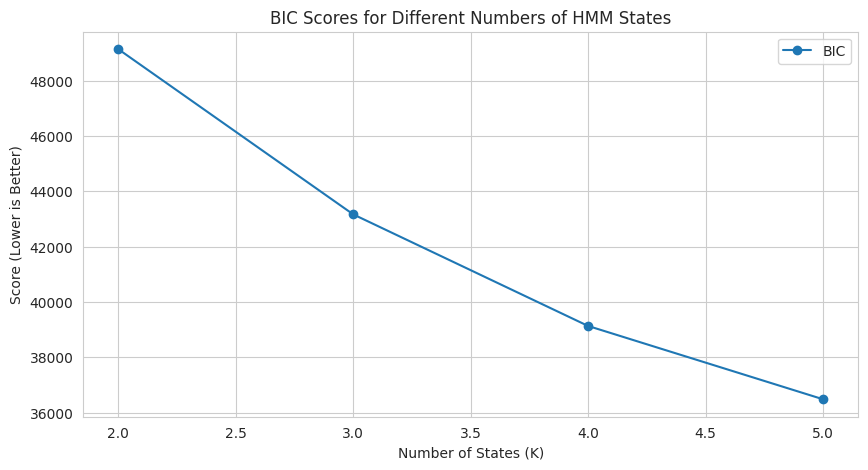

In [19]:
bic_scores = []
n_states_range = range(2, 6) # Test for 2, 3, 4, 5 regimes

print("Calculating BIC scores for different numbers of HMM states...")
for n in n_states_range:
    model = hmm.GaussianHMM(n_components=n, covariance_type="full", n_iter=100, random_state=42)
    model.fit(X_scaled)
    bic_scores.append(model.bic(X_scaled))
    print(f"Fitted HMM with {n} states. BIC: {bic_scores[-1]:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(n_states_range, bic_scores, marker='o', label='BIC')
plt.title('BIC Scores for Different Numbers of HMM States')
plt.xlabel('Number of States (K)')
plt.ylabel('Score (Lower is Better)')
plt.legend()
plt.show()

Cell 4: Fit Final HMM with Optimal K


Based on the plot, K=3 appears to be a good choice as it provides a significant drop in the BIC score. Let's proceed with fitting our final HMM with 3 states.

In [20]:
K = 3
final_model = hmm.GaussianHMM(n_components=K, covariance_type="full", n_iter=200, random_state=42)
final_model.fit(X_scaled)

# Predict the hidden states (regimes) for each day
hidden_states = final_model.predict(X_scaled)
features_df['Regime'] = hidden_states

print(f"Final HMM with K={K} has been fitted and states have been predicted.")

Final HMM with K=3 has been fitted and states have been predicted.


Cell 5: Analyze the Characteristics of Each Regime


Now, let's analyze the average characteristics of our features within each regime. This helps us give each state a meaningful label (e.g., 'Bull Market', 'Bear Market').

regime_characteristics = features_df.groupby('Regime')[['Returns', 'Volatility', 'Momentum', 'Intraday_Range']].mean()

print("Average Characteristics per Regime:")
print(regime_characteristics)

In [21]:
regime_characteristics = features_df.groupby('Regime')[['Returns', 'Volatility', 'Momentum', 'Intraday_Range']].mean()

print("Average Characteristics per Regime:")
print(regime_characteristics)

Average Characteristics per Regime:
         Returns  Volatility  Momentum  Intraday_Range
Regime                                                
0       0.000715    0.095786  0.260654        0.007697
1      -0.000011    0.176464 -0.031435        0.014099
2      -0.000618    0.356771 -0.348267        0.027072


Cell 6: Visualize the Regimes


The most powerful visualization is to plot the S&P 500 price and color the background according to the regime identified by the HMM. This will show us if the model's segmentation makes intuitive sense.

/tmp/ipython-input-3778784360.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)


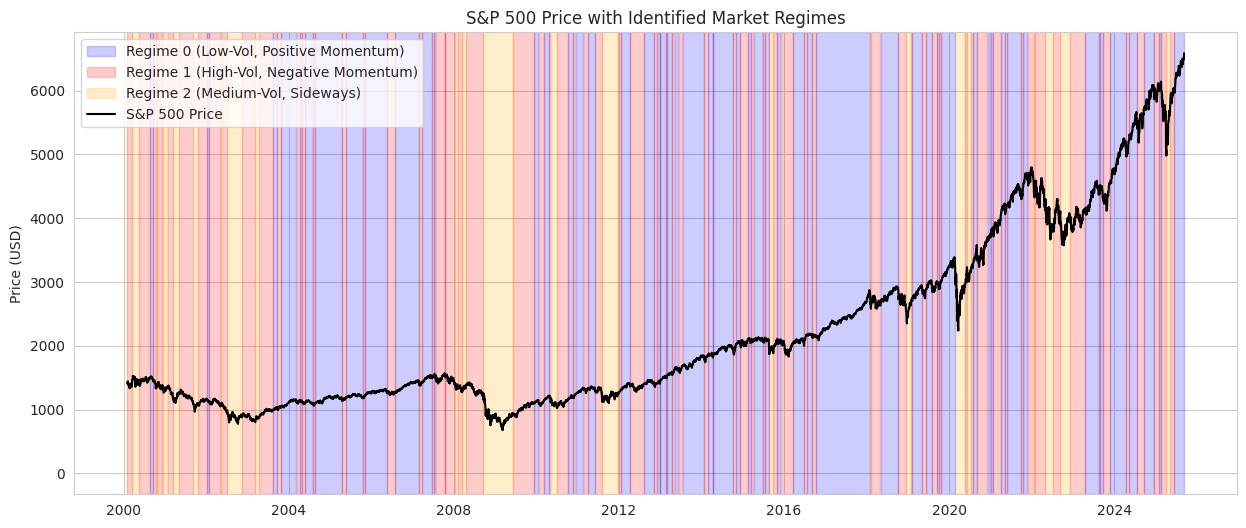

In [22]:
# Load the original price data to plot alongside the regimes
TICKER = '^GSPC'
START_DATE = '2000-01-01'
END_DATE = '2025-09-12'
price_df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
price_df = price_df.loc[features_df.index]

fig, ax = plt.subplots(figsize=(15, 6))

# Define colors and labels for our interpretation of the regimes
colors = ['blue', 'red', 'orange']
regime_labels = {
    0: 'Regime 0 (Low-Vol, Positive Momentum)',
    1: 'Regime 1 (High-Vol, Negative Momentum)',
    2: 'Regime 2 (Medium-Vol, Sideways)'
}


for k in range(K):
    state = (features_df['Regime'] == k)
    ax.fill_between(features_df.index, 0, 1, where=state, alpha=0.2, transform=ax.get_xaxis_transform(), color=colors[k], label=regime_labels.get(k))

ax.plot(price_df.index, price_df['Close'], label='S&P 500 Price', color='black')
ax.set_title('S&P 500 Price with Identified Market Regimes')
ax.set_ylabel('Price (USD)')
ax.legend()
plt.show()

Cell 7: Save Results for the Next Notebook


Finally, we get the posterior probabilities (gammas) which will be our gating signal, and save everything to a new CSV file.



In [23]:
# Get the posterior probabilities (gammas) for the gating network
# Note: hmmlearn's predict_proba provides smoothed posteriors (uses future info).
# For a live system, a causal, forward-only filter would be required.
gammas = final_model.predict_proba(X_scaled)
gamma_df = pd.DataFrame(gammas, index=features_df.index, columns=[f'gamma_{k}' for k in range(K)])

# Combine everything into one final dataframe
final_df = features_df.join(gamma_df)

OUTPUT_FILENAME = 'features_with_regimes.csv'
final_df.to_csv(OUTPUT_FILENAME)

print(f"Final dataset with regime labels and posteriors saved to {OUTPUT_FILENAME}")
print(final_df.head())

Final dataset with regime labels and posteriors saved to features_with_regimes.csv
             Returns  Volatility  Momentum  Intraday_Range  Regime  \
Price                                                                
2000-02-02 -0.000114    0.257009 -0.386300        0.012149       2   
2000-02-03  0.011185    0.220892  0.217114        0.019130       1   
2000-02-04 -0.000421    0.220900  0.189016        0.010728       1   
2000-02-07 -0.000091    0.220917  0.176459        0.009703       1   
2000-02-08  0.012198    0.204466  0.002081        0.012201       1   

                  gamma_0        gamma_1   gamma_2  
Price                                               
2000-02-02   0.000000e+00  6.155901e-217  1.000000  
2000-02-03  8.900589e-130   9.322043e-01  0.067796  
2000-02-04   8.998875e-10   9.973227e-01  0.002677  
2000-02-07   8.699119e-10   9.998731e-01  0.000127  
2000-02-08   3.298051e-09   9.999875e-01  0.000013  
